# <span style="color:#336699">Plausability study of swissEO VHI values</span>
<hr style="border:2px solid #0077b9;">
<div style="text-align: left;">
    <a href="https://nbviewer.org/github/swisstopo/topo-satromo/blob/dev-20241209/codegallery/jupyter/Python/stac/vhi-plausability.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" align="center"/></a>
</div>
<br>
<b>Abstract.</b> This Jupyter Notebook leads through the plausability study of the swissEO VHI product from data.geo.admin.ch and compares it with various data sources:

  - Combined drought index (CDI)
  - Treenet
  - Sanasilva
</div>

<hr style="border:1px solid #0077b9;">

# Set up connection to the STAC
<div>

Following packages are recquired: 

In [32]:
!pip install pystac-client
#!pip install rasterio
#!pip install shapely
!pip install matplotlib
!pip install pandas
!pip install geopandas
!pip install numpy
!pip install datetime
!pip install seaborn
!pip install scipy


[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
import pystac_client
import pandas as pd
import geopandas as gpd
import numpy as np
from datetime import timedelta

Creating a STAC object attached to the data.geo.admin.ch STAC service (due to the swisstopo specific STAC implementaion, we need to add the conrformance classes).

In [34]:
service = pystac_client.Client.open('https://data.geo.admin.ch/api/stac/v0.9/')
service.add_conforms_to("COLLECTIONS")
service.add_conforms_to("ITEM_SEARCH")

for collection in service.get_collections():
    if "swisseo" in collection.id.lower():
        print(collection)

<CollectionClient id=ch.swisstopo.swisseo_s2-sr_v100>
<CollectionClient id=ch.swisstopo.swisseo_vhi_v100>


<hr style="border:1px solid #0077b9;">

# Merging CDI data with the respective VHI values
<div>

The data provided by MeteoSwiss is a table of weekly values for each warning region (n = 38). The data covers the years 1991-2022 for the variables CDI, precipitation sums (1m, 3m, 24m), water bodies, and soil moisture. For each of the variables, there are classified values between 1 (non-concerning values regarding drought) and 5 (severe drought conditions).

First, the data needs to be loaded.

In [35]:
df = pd.read_csv('https://gist.githubusercontent.com/Tschoun/7b7d46a31303f41dee39a6f051aed55f/raw/c269b491802b39f7c1f4bded411b6ef3f7dbfc5b/CDI_1991-01-01_2022-12-31.csv',
                 sep = ';')
df.loc[:, 'Region_ID'] = df['Region_ID'] + 30 # to match the Region_IDs used across the drought platform
# df.head()

If we're only working with the VHI derived from Sentinel-2 data we can remove all the entries before Sentinel-2 data was available operationally.

In [36]:
df['Datum'] = pd.to_datetime(df['Datum'])
df_S2 = df[df['Datum'] > '2017-04-03'] # first swissEO VHI product dates from 2017-04-04
df_S2.head()

,Datum,Region_ID,NiedSumme1M,NiedSumme3M,NiedSumme24M,Gewässer,Bodenfeuchte,CDI
52060,2017-04-09,31,5,1,1,4,3,4
52061,2017-04-09,32,5,1,1,3,3,3
52062,2017-04-09,33,5,1,1,1,2,2
52063,2017-04-09,34,4,1,1,3,1,3
52064,2017-04-09,35,2,1,1,1,1,1


New columns need to be added to the dataframe:

- 'VHI': VHI value [-; 0-100] (classified vegetation health values -> 0-9: extremely stressed, 10-19: severely stressed, 20-29: stressed, 30-39: moderately stressed, 40-49: normal, 50-59: good, 60-100: excellent, 110: no data)
- 'DiffD': The difference between the date of the CDI and the last VHI value [d]. Optimally this will be zero, meaning there's a VHI product for the specific date, in case of no available VHI product on that date, it will take the last available one previous to the that date and declare in this column how many days earlier the VHI product is from.
- 'Availability': The availability of VHI values within the region [%].
- *'Current': The amount of VHI values within this weekly composite that originate from the newest scene [%]. Because the VHI product takes all the swissEO S2-SR scenes within a 7d time frame previous to the specified date into account, it's possible that most of the VHI values are a few days older depending on the newest orbit and the extent of the cloud mask.*

First of all, we extract the 'VHI' values and the 'Availability' from the swissEO VHI geojson datasets for the forest regions. Forests are chosen because their signal is more robust, as they are less managed than agricultural lands. 

In [37]:
item_search = service.search(
    datetime='2017-04-04/2022-12-31',
    collections=['ch.swisstopo.swisseo_vhi_v100']
)
for item in item_search.items():
    assets = item.assets
asset_key = next((key for key in assets.keys() if key.endswith('forest-warnregions.geojson')), None)
metadata_asset = assets[asset_key ]

gdf = gpd.read_file(metadata_asset.href)
properties = gdf[['REGION_NR', 'vhi_mean', 'availability_percentage']]
properties = properties.replace(110, np.nan)
# properties.head()

We need to know the date of the VHI values. We're looking for the same date as the CDI value. If there's no VHI product from that date, we take the latest product prior to that date.

In [38]:
unique_dates = df_S2['Datum'].unique()

results = []

for date in unique_dates:
    # Convert date to string format expected by STAC API
    date_str = date.strftime('%Y-%m-%d')
    
    # Search for exact date
    item_search = service.search(
        datetime=f'{date_str}/{date_str}',
        collections=['ch.swisstopo.swisseo_vhi_v100']
    )
    
    items = list(item_search.items())
    
    # If no items found, search for the last item before the date
    if not items:
        search_date = date
        while not items and search_date > df_S2['Datum'].min():
            search_date -= timedelta(days=1)
            item_search = service.search(
                datetime=f'{search_date.strftime("%Y-%m-%d")}/{search_date.strftime("%Y-%m-%d")}',
                collections=['ch.swisstopo.swisseo_vhi_v100']
            )
            items = list(item_search.items())
    
    if items:
        item = items[0]  # Take the first item if multiple are found
        assets = item.assets
        asset_key = next((key for key in assets.keys() if key.endswith('forest-warnregions.geojson')), None)
        
        if asset_key:
            metadata_asset = assets[asset_key]
            gdf = gpd.read_file(metadata_asset.href)
            properties = gdf[['REGION_NR', 'vhi_mean', 'availability_percentage']]
            properties = properties.replace(110, np.nan)
            
            # Add the original date and the actual date of the data
            properties['Datum'] = date
            properties['ActualDate'] = item.datetime.date()
            
            # Calculate DiffD
            # properties['DiffD'] = (date - item.datetime.date()).days
            
            results.append(properties)

# Combine all results into a single DataFrame
final_results = pd.concat(results, ignore_index=True)
# final_results.iloc[160:171]


Because the date of the last VHI product does not always match the date of the CDI, the delay in days is calculated.

In [39]:
# Convert columns to datetime if they're not already
final_results['Datum'] = pd.to_datetime(final_results['Datum'])
final_results['ActualDate'] = pd.to_datetime(final_results['ActualDate'])

# Calculate the difference in days
final_results['DaysDifference'] = (final_results['Datum'] - final_results['ActualDate']).dt.days
final_results = final_results.rename(columns={
    'REGION_NR': 'Region_ID',
    'vhi_mean': 'VHI',
    'availability_percentage': 'Availability',
    'DaysDifference': 'DiffD'
})
# final_results.iloc[160:171]

Now the two data frames need to be merged.

In [40]:
# Merge the DataFrames
df_merged = df_S2.merge(final_results[['Datum', 'Region_ID', 'VHI', 'Availability', 'DiffD']], 
                        on=['Datum', 'Region_ID'], 
                        how='left')
df_merged.iloc[150:155]

,Datum,Region_ID,NiedSumme1M,NiedSumme3M,NiedSumme24M,Gewässer,Bodenfeuchte,CDI,VHI,Availability,DiffD
150,2017-04-30,67,1,1,1,1,4,1,NaN,NaN,7
151,2017-04-30,68,1,1,1,2,5,2,NaN,NaN,7
152,2017-05-07,31,1,1,3,1,1,1,35.0,20.8,14
153,2017-05-07,32,1,1,1,1,1,1,28.0,31.5,14
154,2017-05-07,33,1,1,1,1,1,1,46.0,48.8,14


In [72]:
# Create columns for the time-shifted VHI (positive shift, takes a VHI earlier than the CDI)
time_shifts = [0, 2, 4, 6, 8]  # Example time shifts in weeks
for shift in time_shifts:
    df_merged.loc[:, f'VHI_shifted_{shift}'] = df_merged.groupby('Region_ID')['VHI'].shift(shift)

To do:
- *Adding the column 'Current' to state how much of the VHI value is from the lates available swissEO S2-SR product.*
- *für historische Werte, alle Daten in Monat mit VHI dieses Monats ergänzen*

<hr style="border:1px solid #0077b9;">

# Comparison of the MeteoSwiss vs. swisstopo VHI values
<div>

- Column “Datum” corresponds to the Sunday of the given week, as with CDI data.
- For traceability, I add columns “startday” and “endday”. These indicate exactly what days are used to compute the weekly average. This is because while the weeks follow calendar weeks, the processing around 31 Dec / 1. Jan has two twists:
    1)	If the first week would contain days from the previous year, those days are ignored
    2)	The last week also includes any remaining days until Dec. 31
- “nanfrac” is fraction of missing values (0-1). Pixels that are always NA (e.g. lakes) do not contribute to nanfrac.


In [73]:
df_vhi_mch = pd.read_csv('https://gist.githubusercontent.com/Tschoun/1899bdf3e3759dee23cc8e9b1bf21570/raw/6dffa9b37d1832f31bd87c5211f19a6e28bc7e91/VHI_MCH',
                 sep = ';')
df_vhi_mch['Datum'] = pd.to_datetime(df_vhi_mch['Datum'])
df_vhi_mch = df_vhi_mch[df_vhi_mch['Datum'] > '2017-04-03'] # first swissEO VHI product dates from 2017-04-04
df_vhi_mch = df_vhi_mch.rename(columns={'VHI': 'VHI_MCH'})
df_vhi_mch.head()

,Datum,Region_ID,VHI_MCH,nanfrac,startday,endday
33326,2017-04-09,31,47.77,0.0,2017-04-03,2017-04-09
33327,2017-04-09,32,47.14,0.0,2017-04-03,2017-04-09
33328,2017-04-09,33,49.90,0.0,2017-04-03,2017-04-09
33329,2017-04-09,34,48.50,0.0,2017-04-03,2017-04-09
33330,2017-04-09,35,43.05,0.0,2017-04-03,2017-04-09


In [74]:
# Merge the DataFrames
df_cdi_vhi = df_merged.merge(df_vhi_mch[['Datum', 'Region_ID', 'VHI_MCH', 'nanfrac', 'startday', 'endday']], 
                        on=['Datum', 'Region_ID'], 
                        how='left')
df_cdi_vhi = df_cdi_vhi.rename(columns={'VHI': 'VHI_swisstopo'})
df_cdi_vhi.iloc[150:155]
print('Min VHI (MCH): ',min(df_cdi_vhi.loc[:,'VHI_MCH']))
print('Max VHI (MCH): ',max(df_cdi_vhi.loc[:,'VHI_MCH']))

Min VHI (MCH):  8.96
Max VHI (MCH):  71.55


Comparing the two VHI values:

In [75]:
# Filter the DataFrame
df_filtered_vhi = df_cdi_vhi

# Minimum of x % VHI availability within the region
# df_filtered_vhi = df_filtered_vhi[(df_filtered_vhi['Availability'] > 20)]

# Maximum of x days time difference between CDI and VHI
# Keep in mind that if there's no VHI product, the values within the last product are
# already seven days old.
# df_filtered_vhi = df_filtered_vhi[(df_filtered_vhi['DiffD'] < 7)]

# Filter for time period between dates
# start_date = '2021-03-01'
# end_date = '2021-09-30'
# title = str(start_date) + ' to ' + str(end_date)
# df_filtered_vhi = df_filtered_vhi[(df_filtered_vhi['Datum'] > start_date) & (df_filtered_vhi['Datum'] < end_date)] 

# Filter for specific months (e.g. summer season)
df_filtered_vhi.loc[:,'Datum'] = pd.to_datetime(df_filtered_vhi['Datum'])
months_to_filter = list(range(4, 11)) # does not include the end number
month_names = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}
title = f"{month_names[min(months_to_filter)]} to {month_names[max(months_to_filter)]}"
df_filtered_vhi = df_filtered_vhi[df_filtered_vhi['Datum'].dt.month.isin(months_to_filter)]

# Filter for specific region(s)
# df_filtered_vhi = df_filtered_vhi[(df_filtered_vhi['Region_ID'] == 42)]

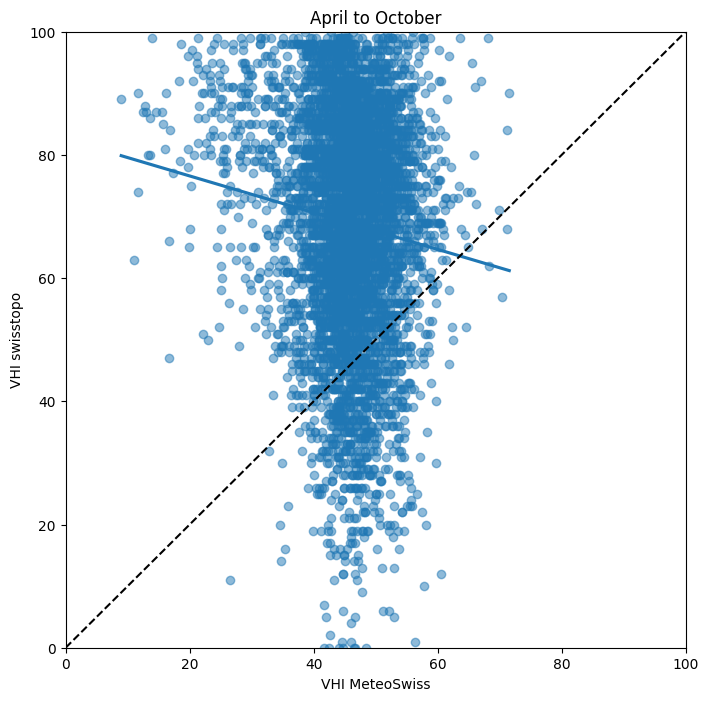

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a scatterplot with a 1:1 line and a trendline
plt.figure(figsize=(8, 8))
ax = sns.regplot(x='VHI_MCH', y='VHI_swisstopo', data=df_filtered_vhi, ci=None, scatter_kws={'alpha': 0.5})

# Add a 1:1 line
plt.plot([0, 100], [0, 100], 'k--')

# Add a title and labels
plt.title(title)
plt.xlabel('VHI MeteoSwiss')
plt.ylabel('VHI swisstopo')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

# Show the plot
plt.show()

In [45]:
# Export to csv
# df_cdi_vhi.to_csv('D:/Users/joan-sturm-w1/Documents/CDI_VHI_MCH-swisstopo_warnregionen.csv', index=False)

<hr style="border:1px solid #0077b9;">

# Comparison of CDI and VHI values
<div>

To compare a categorical variable (CDI) with a continuous variable (VHI), you can use several methods:
- Box plots: Create side-by-side box plots for each CDI category (1-5) to visualize the distribution of VHI values. This will help you see if there's a trend of lower VHI values for higher CDI categories.
- One-way ANOVA: If the VHI values are normally distributed within each CDI category, use a one-way ANOVA to test for significant differences in mean VHI across CDI categories.
- Kruskal-Wallis test: If the VHI values are not normally distributed, use this non-parametric alternative to one-way ANOVA.
- Spearman's rank correlation: Since CDI is ordinal (1-5) and you expect an inverse relationship with VHI, calculate Spearman's correlation coefficient to measure the strength and direction of association.
- Visualization: Create a scatter plot with CDI on the x-axis and VHI on the y-axis. Add a trend line to visualize the relationship.
- Chi-square test for trend: If you categorize VHI into bins, you can use this test to assess if there's a significant trend across CDI categories.


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [86]:
# Filter the DataFrame
df_filtered = df_cdi_vhi

# Minimum of x % VHI availability within the region
df_filtered = df_filtered[(df_filtered['Availability'] > 20)]

# Maximum of x days time difference between CDI and VHI
# Keep in mind that if there's no VHI product, the values within the last product are
# already seven days old.
df_filtered = df_filtered[(df_filtered['DiffD'] < 7)]

# Filter for time period between dates
# start_date = '2018-04-01'
# end_date = '2018-10-31'
# title = str(start_date) + ' to ' + str(end_date)
# df_filtered = df_filtered[(df_merged['Datum'] > start_date) & (df_merged['Datum'] < end_date)] 

# Filter for specific months (e.g. summer season)
df_filtered.loc[:,'Datum'] = pd.to_datetime(df_filtered['Datum'])
months_to_filter = list(range(4, 11)) # does not include the end number
month_names = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}
title = f"{month_names[min(months_to_filter)]} to {month_names[max(months_to_filter)]}"
df_filtered = df_filtered[df_filtered['Datum'].dt.month.isin(months_to_filter)]

# Filter for specific year
# year = 2018
# title = title + ' ' + str(year)
# df_filtered = df_filtered[df_filtered['Datum'].dt.year == year]

# Filter for specific region(s)
# df_filtered = df_filtered[(df_merged['Region_ID'] == 42)]


## Box plots:

<Figure size 1000x600 with 0 Axes>

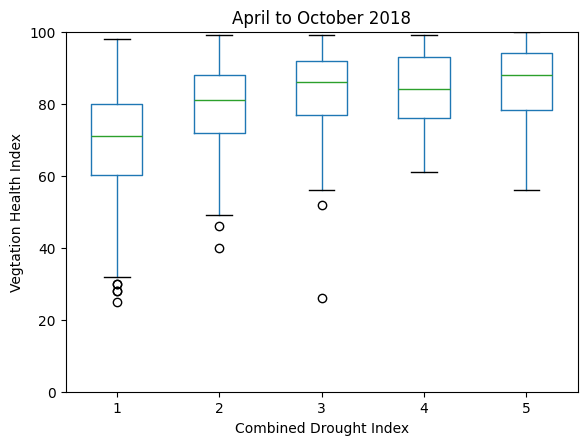

In [79]:
plt.figure(figsize=(10, 6))
ax = df_filtered.boxplot(column='VHI_swisstopo', by='CDI')
plt.xlabel('Combined Drought Index')
plt.ylabel('Vegtation Health Index')
plt.grid(False)
plt.title(title)
ax.get_figure().suptitle('', y = 1.0)
ax.set_xlim(0.5, 5.5)
ax.set_ylim(0, 100)
plt.show()

Not what we expected. A high CDI and a low VHI both mean dry or stressfull conditions. Does not change much when adjusting the thresholds.

We suspect a time lag, with the VHI reacting later. 

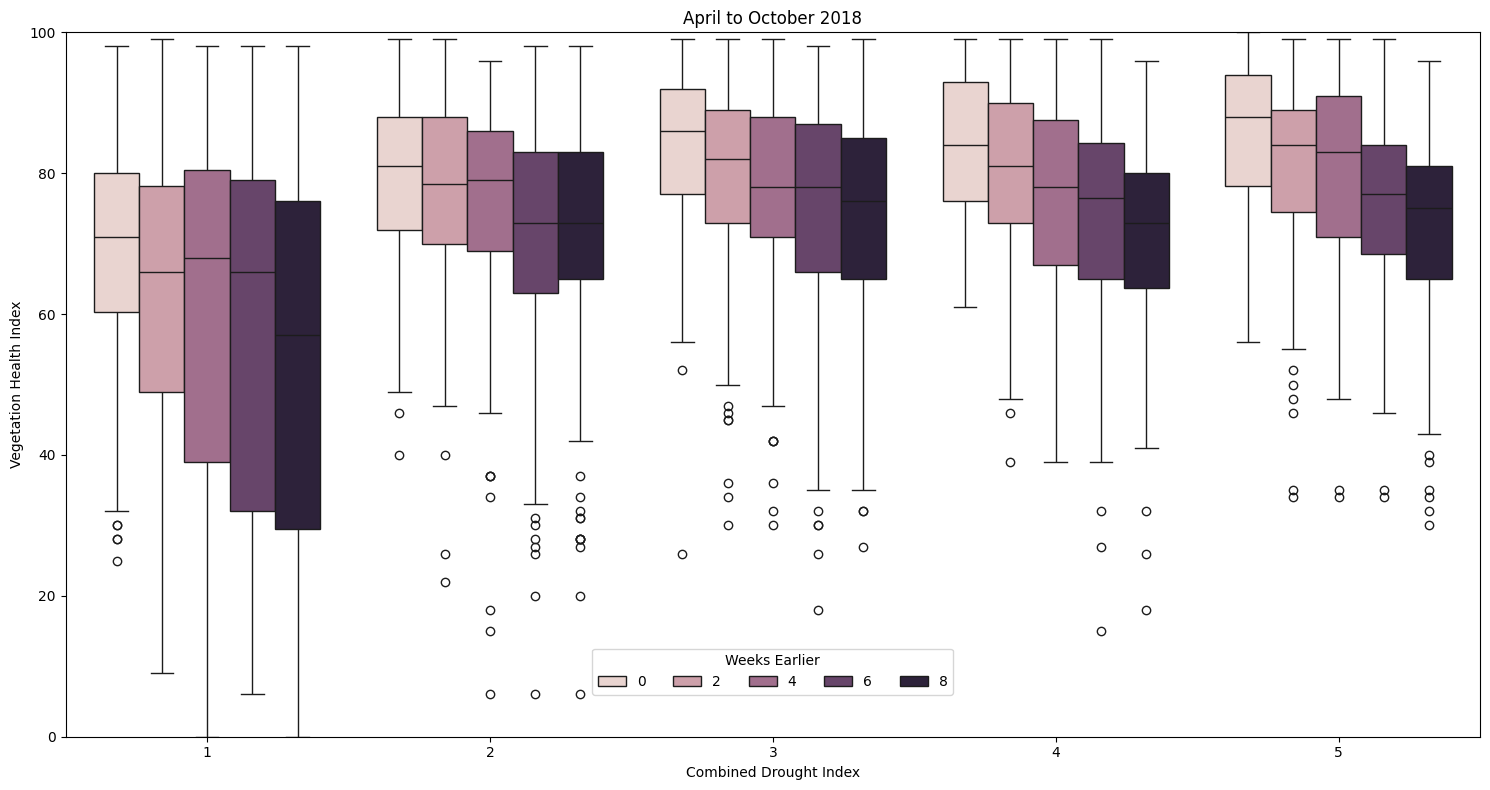

In [80]:
# Create columns for the time-shifted VHI (positive shift, takes a VHI earlier than the CDI)
time_shifts = [0, 2, 4, 6, 8]  # Example time shifts in weeks

# Reshape data to long format
df_melted = df_filtered.melt(id_vars=['CDI', 'Region_ID'], 
                             value_vars=[f'VHI_shifted_{shift}' for shift in time_shifts],
                             var_name='Shift', value_name='VHI_value')
df_melted['Shift'] = df_melted['Shift'].str.extract('(\d+)').astype(int)

cdi_categories = [1, 2, 3, 4, 5]
df_melted['CDI'] = pd.Categorical(df_melted['CDI'].round(), categories=cdi_categories, ordered=True)

plt.figure(figsize=(15, 8))
ax = sns.boxplot(x='CDI', y='VHI_value', hue='Shift', data=df_melted, order=cdi_categories)
plt.xlabel('Combined Drought Index')
plt.ylabel('Vegetation Health Index')
plt.grid(False)
plt.title(title)
plt.legend(title='Weeks Earlier', loc='lower center', bbox_to_anchor=(0.5, 0.05), ncol=len(time_shifts))
ax.set_xlim(-0.5, 4.5)
ax.set_xticks(range(5))
ax.set_xticklabels(cdi_categories)
ax.set_ylim(0, 100)
plt.tight_layout()
plt.show()

## Test if VHI values are normally distributed within a CDI class.
- In the Q-Q plot, if the points closely follow the diagonal line, it suggests normality.
- For the Shapiro-Wilk test, if the p-value is less than 0.05, reject the null hypothesis and conclude the data is not normally distributed.

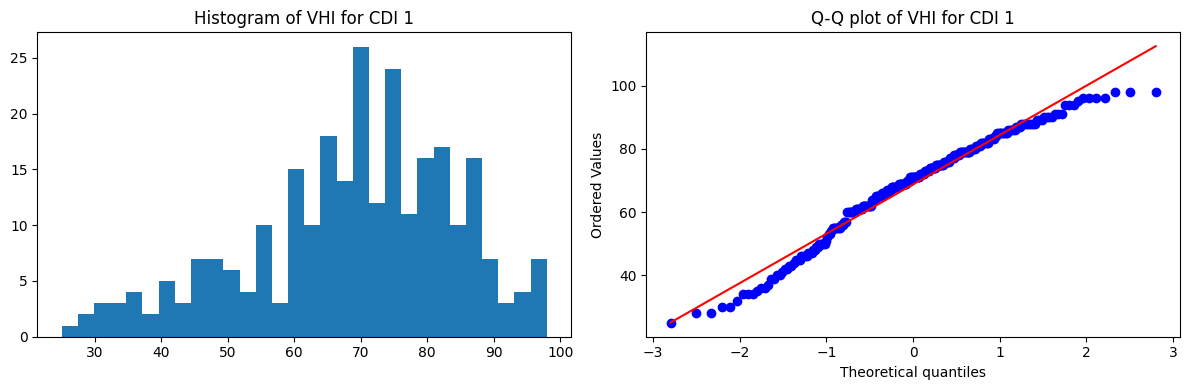

CDI 1:
Number of VHI values: 270
Shapiro-Wilk test statistic: 0.9703054035560024
p-value: 2.1520530683856418e-05
Conclusion:  Not Normal




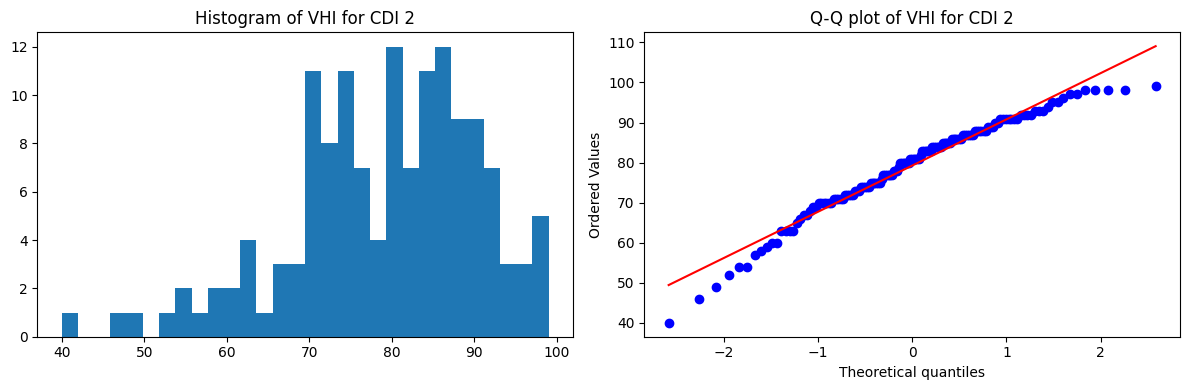

CDI 2:
Number of VHI values: 141
Shapiro-Wilk test statistic: 0.9631922727115567
p-value: 0.0007691441711126245
Conclusion:  Not Normal




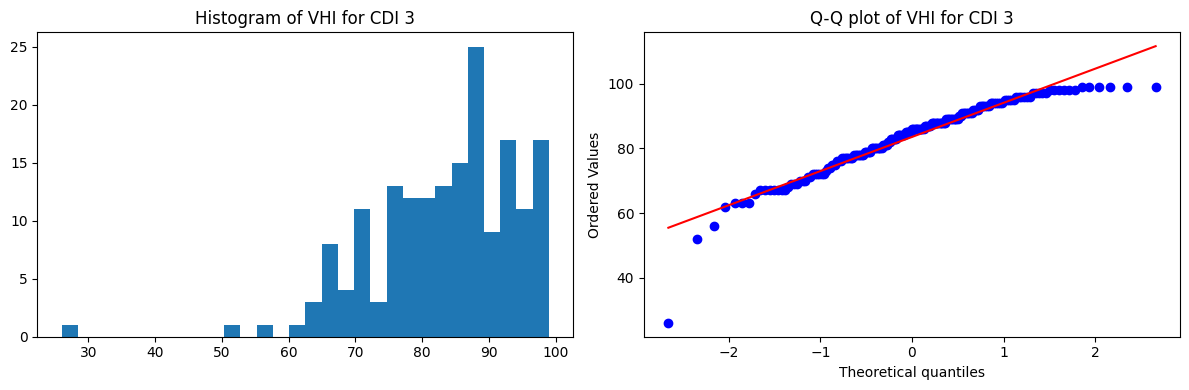

CDI 3:
Number of VHI values: 177
Shapiro-Wilk test statistic: 0.9272718266010502
p-value: 9.485138718724425e-08
Conclusion:  Not Normal




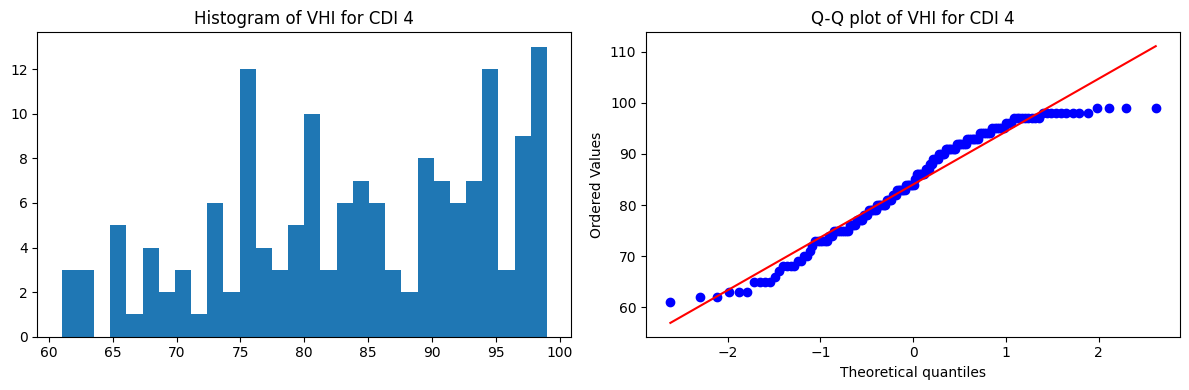

CDI 4:
Number of VHI values: 156
Shapiro-Wilk test statistic: 0.9470394111951295
p-value: 1.2916272270601564e-05
Conclusion:  Not Normal




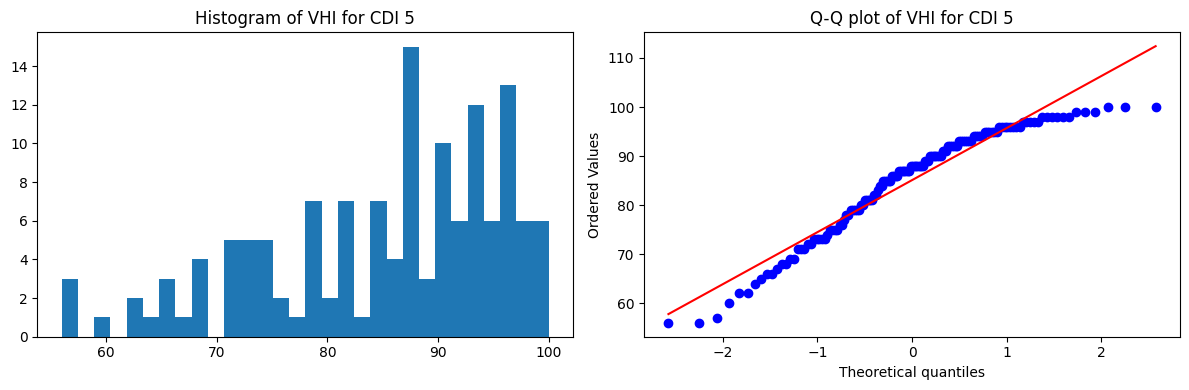

CDI 5:
Number of VHI values: 138
Shapiro-Wilk test statistic: 0.9304021996253895
p-value: 2.5551732176502624e-06
Conclusion:  Not Normal




In [81]:
sorted_cdi = sorted(df_filtered['CDI'].unique())

for cdi in sorted_cdi:
    vhi_values = df_filtered[df_filtered['CDI'] == cdi]['VHI_swisstopo']
    
    # Count the number of VHI values
    vhi_count = vhi_values.count()
    
    # Visual methods
    plt.figure(figsize=(12, 4))
    
    # Histogram
    plt.subplot(121)
    plt.hist(vhi_values, bins=30)
    plt.title(f'Histogram of VHI for CDI {cdi}')
    
    # Q-Q plot
    plt.subplot(122)
    stats.probplot(vhi_values, dist="norm", plot=plt)
    plt.title(f'Q-Q plot of VHI for CDI {cdi}')
    
    plt.tight_layout()
    plt.show()
    
    # Shapiro-Wilk test
    statistic, p_value = stats.shapiro(vhi_values)
    print(f"CDI {cdi}:")
    print(f"Number of VHI values: {vhi_count}")
    print(f"Shapiro-Wilk test statistic: {statistic}")
    print(f"p-value: {p_value}")
    print("Conclusion: ", "Normal" if p_value > 0.05 else "Not Normal")
    print("\n")

## Spearman's rank correlation
A non-parametric test that measures the strength and direction of the relationship between two variables. It's similar to the Pearson correlation coefficient, but it's used for ordinal or ranked data, rather than continuous data
1. The data is first ranked, with the smallest value getting a rank of 1, the next smallest value getting a rank of 2, and so on.
2. The ranks are then used to calculate the correlation coefficient, which measures the strength and direction of the relationship between the two variables.
3. The correlation coefficient ranges from -1 (perfect negative correlation) to 1 (perfect positive correlation), with 0 indicating no correlation. If the correlation is positive, it means that as 'CDI' increases, 'VHI' also tends to increase. If the correlation is negative, it means that as 'CDI' increases, 'VHI' tends to decrease.



In [87]:
from scipy.stats import spearmanr

# Create columns for the time-shifted VHI (positive shift, takes a VHI earlier than the CDI)
time_shifts = [0, 2, 4, 6, 8]  # Example time shifts in weeks
for shift in time_shifts:
    vhi_shifted = df_filtered[f'VHI_shifted_{shift}'].dropna()
    cdi = df_filtered['CDI'].dropna()

    # Make sure the indices are aligned
    common_indices = vhi_shifted.index.intersection(cdi.index)
    vhi_shifted = vhi_shifted.loc[common_indices]
    cdi = cdi.loc[common_indices]

    correlation, p_value = spearmanr(cdi, vhi_shifted)

    print(f'VHI_shifted_{shift}')
    print(f"Spearman's rank correlation: {correlation}")
    print(f"P-value: {p_value:.4f}", " (not significant)" if p_value > 0.05 else "(significant)")
    print("Conclusion: ", "Increasing VHI with increasing CDI \n" if correlation > 0 
          else "Decreasing VHI with increasing CDI \n")

VHI_shifted_0
Spearman's rank correlation: 0.3374297216600801
P-value: 0.0000 (significant)
Conclusion:  Increasing VHI with increasing CDI 

VHI_shifted_2
Spearman's rank correlation: 0.29756726324733646
P-value: 0.0000 (significant)
Conclusion:  Increasing VHI with increasing CDI 

VHI_shifted_4
Spearman's rank correlation: 0.28270407164809325
P-value: 0.0000 (significant)
Conclusion:  Increasing VHI with increasing CDI 

VHI_shifted_6
Spearman's rank correlation: 0.2597290040076598
P-value: 0.0000 (significant)
Conclusion:  Increasing VHI with increasing CDI 

VHI_shifted_8
Spearman's rank correlation: 0.2597787938624697
P-value: 0.0000 (significant)
Conclusion:  Increasing VHI with increasing CDI 



To do:
- *filter for availability*
- *only summer half year*
- *Comparison between different warn regions, does it work better in certain areas?*